Url: https://tbrain.trendmicro.com.tw/Competitions/Details/2

In [738]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import col, udf, lag, rank, lit, trim
from pyspark.sql.window import Window

In [795]:
global Path
global DoEval #是否進行模型評估

#DoEval = False
#next_date_range = ["20180521", "20180522", "20180523", "20180524", "20180525"] #設定預測區間
DoEval = True
next_date_range = ["20180514", "20180515", "20180516", "20180517", "20180518"] #設定預測區間
ignore_dates = [""]#設定排除日(如端午節)
#next_date_range = ["20180507", "20180508", "20180509", "20180510", "20180511"] #設定預測區間
#ignore_dates = [""]#設定排除日(如端午節)
#next_date_range = ["20180430", "20180501", "20180502", "20180503", "20180504"] #設定預測區間
#ignore_dates = ["20180501"]#設定排除日(如端午節)
predict_start_date = next_date_range[0]

if sc.master[0:5]=="local":
    #Path = "file:/c:/D Drive/work/bigData/pySpark/TBrain_Round2_DataSet_20180511"
    #Path = "file:/Users/yungchuanlee/Documents/learn/AI競賽/ETF預測/TBrain_Round2_DataSet_20180511"
    Path = "file:/home/hduser/app/bigdata/competition/etf/TBrain_Round2_DataSet_20180518"
else:
    Path = "hdfs://master:9000/user/hduser"
Path = "file:/home/hduser/app/bigdata/competition/etf/TBrain_Round2_DataSet_20180518"

In [796]:
sc.master

'spark://sparklab:7077'

In [797]:
#define alias of columns
col_alias_etf= {"代碼":"etf_id", "日期": "etf_date", "中文簡稱": "etf_name", "開盤價(元)":"etf_open", 
            "最高價(元)":"etf_high", "最低價(元)":"etf_low", "收盤價(元)":"etf_close", "成交張數(張)":"etf_count"}
col_alias_stock= {"代碼":"stock_id", "日期": "stock_date", "中文簡稱": "stock_name", "開盤價(元)":"stock_open", 
            "最高價(元)":"stock_high", "最低價(元)":"stock_low", "收盤價(元)":"stock_close", "成交張數(張)":"stock_count"}

In [798]:
#udf
def to_double(str_val):
    return float(str_val.replace(",",""))
to_double=udf(to_double)

In [799]:
#def function to read data (因檔案格式都相同)
def read_data(file_name, col_alias):
    str_cols = ["代碼","日期", "中文簡稱"]
    raw_data = spark.read.option("encoding", "Big5").csv(Path + "/" + file_name, header=True, sep=",")
    print("Total " + file_name + " count: " + str(raw_data.count()))
    #rename cols and correct type 
    num_cols = [col_name for col_name in raw_data.columns if col_name not in str_cols]
    final_data=raw_data.select( [col(str_col_name).alias(col_alias[str_col_name]) for str_col_name in str_cols] + 
                                  [to_double(col(num_col_name)).cast("double").alias(col_alias[num_col_name]) for num_col_name in num_cols] )
    final_data.printSchema()
    final_data.show(5)
    return final_data

In [800]:
print("starting import tetfp.csv(台灣18檔ETF股價資料)...")
tetfp_dt=read_data("tetfp.csv", col_alias_etf)

starting import tetfp.csv(台灣18檔ETF股價資料)...
Total tetfp.csv count: 19306
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)

+-------+--------+----------------+--------+--------+-------+---------+---------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|
+-------+--------+----------------+--------+--------+-------+---------+---------+
|0050   |20130102|元大台灣50          |    54.0|   54.65|   53.9|     54.4|  16487.0|
|0050   |20130103|元大台灣50          |    54.9|   55.05|  54.65|    54.85|  29020.0|
|0050   |20130104|元大台灣50          |   54.85|   54.85|   54.4|     54.5|   9837.0|
|0050   |20130107|元大台灣50          |   54.55|   54.55|   53.9|    54.25|   8910.0|
|0050   |20130108|元大台灣50     

In [801]:
#EDA
#range of date
tetfp_dt.describe('etf_date').show()

+-------+--------------------+
|summary|            etf_date|
+-------+--------------------+
|  count|               19306|
|   mean|2.0153649878068995E7|
| stddev|    15917.8419890693|
|    min|            20130102|
|    max|            20180518|
+-------+--------------------+



In [802]:
# print("starting import taetfp.csv(台灣18檔ETF調整後股價資料)...")
# taetfp_dt=read_data("taetfp.csv", col_alias_etf)

In [803]:
# print("starting import tsharep.csv(台灣個股股價資料)...")
# tsharep_dt=read_data("tsharep.csv", col_alias_stock)

In [804]:
# print("starting import tasharep.csv(台灣個股調整後股價資料)...")
# tasharep_dt=read_data("tasharep.csv", col_alias_stock)

In [805]:
import sys
from pyspark.sql.functions import lag, col, avg,collect_list, lit
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType, IntegerType
#declare previous row windows
wsSpec_etf = Window.partitionBy('etf_id').orderBy('etf_date') #time window for normal case
wsSpec_etf_close_price_raw = Window.partitionBy('etf_id').orderBy('row_idx').rangeBetween(-sys.maxsize, -1)
wsSpec_etf_dif_raw = Window.partitionBy('etf_id').orderBy('row_idx').rangeBetween(-sys.maxsize, 0)
def avg_list(p_list):
    #計算數字list的平均值
    return sum(p_list)/len(p_list)
#calculate MA
def calculate_ma_native(close_p_list, window_len):
    if len(close_p_list) < window_len:
        return None
    else:
        cal_list = close_p_list[len(close_p_list) - window_len :]
        ma_sum = 0.0
        w_sum = 0.0
        for idx in range(0, len(cal_list)):
            w = idx + 1
            ma_sum += cal_list[idx]*w
            w_sum += w
        return ma_sum/w_sum
calculate_ma = udf(calculate_ma_native, DoubleType())
        
#計算EMA的udf
def calculate_ema_native(close_p_list, window_len):
    #透過歷史收盤價計算
    if len(close_p_list) < window_len:
        return None
    elif len(close_p_list) == window_len:
        #if len of list = win_len then return avg, 
        return avg_list(close_p_list)
    else:
        #else EMA[t] =(EMA[t-1]*(win_len-1)+close[t]*2)/(win_len+1)
        ema = avg_list(close_p_list[:window_len])
        for price in close_p_list[window_len:]:
            ema = (ema*(window_len-1)+price*2)/(window_len+1)
        return ema
calculate_ema=udf(calculate_ema_native, DoubleType())
#計算BIAS的udf
def calculate_bias_native(close_p_list):
    #計算前日收盤價與N日均線之差比: (close price - MA)/MA   ,Paper 建議用20日MA
    #因要預測今日的收盤價，故計算前日收盤價與前20日均線
    if len(close_p_list) < 21:
        return None
    else:
        list_len = len(close_p_list)
        p_close = close_p_list[-1]
        cal_list = close_p_list[list_len-21: list_len-1]
        return p_close - avg_list(cal_list)
calculate_bias=udf(calculate_bias_native, DoubleType())

def get_min_max_last(p_list):
    #找出list中最大最小和最後一個值, 回傳(min, max, last)
    return (min(p_list), max(p_list), p_list[-1])
def calculate_raw_rsv(p_list):
    #RSV = (收盤價-9日低值)/(9日高值-9日低值)
    p_min, p_max, p_last = get_min_max_last(p_list)
    rsv = (p_last - p_min)/(p_max - p_min)
    return rsv
def calculate_rsv(p_9_list, k_prev, d_prev):
    #計算加權後的RSV，p_9_list=>9日收盤價
    rrsv = calculate_raw_rsv(p_9_list)
    k_curr = (1/3)*rrsv + (2/3)*k_prev
    d_curr = (1/3)*k_curr + (2/3)*d_prev
    return [k_curr, d_curr]
#計算隨機指標（Stochastic Oscillator，KD），原名%K&%D
def calculate_KD_native(close_p_list):
    win_len = 9 #看過去 9 日值
    #RSV = (收盤價-9日低值)/(9日高值-9日低值)
    #K_curr = 1/3*RSV + 2/3*K_prev
    #D_curr = 1/3*K_curr + 2/3*D_prev
    if len(close_p_list) < win_len:
        return None
    elif len(close_p_list) == win_len:
        #無前日K, D時，以0.5帶入
        return calculate_rsv(close_p_list, 0.5, 0.5)
    else:
        kds = calculate_rsv(close_p_list[0:9], 0.5, 0.5)
        for idx in range(1, (len(close_p_list)+1-9)):
            p_9_list = close_p_list[idx: idx+9]
            kds = calculate_rsv(p_9_list, kds[0], kds[1])
        return kds
calculate_KD=udf(calculate_KD_native, ArrayType(DoubleType()))

#計算差離值DIF = 12日EMA - 26日EMA
def calculate_DIF_native(close_p_list):
    if len(close_p_list) < 26:
        return None
    else:
        ema12 = calculate_ema_native(close_p_list, 12)
        ema26 = calculate_ema_native(close_p_list, 26)
        return ema12 - ema26
calculate_DIF=udf(calculate_DIF_native, DoubleType())

#計算MACD=(前一日MACD × (9 - 1) + 今日DIF × 2) ÷ (9 + 1)
def calculate_MACD_native(dif_list, dif_curr):
    win_len = 9
    if len(dif_list) < win_len:
        return None
    elif len(dif_list) == win_len:
        #if len of list = win_len then return avg, 
        return avg_list(dif_list)
    else:
        #MACD=(前一日MACD × (9 - 1) + 今日DIF × 2) ÷ (9 + 1)
        macd = avg_list(dif_list[:win_len])
        for price in dif_list[win_len:]:
            macd = (macd*(win_len-1)+dif_curr*2)/(win_len+1)
        return macd
calculate_MACD=udf(calculate_MACD_native, DoubleType())

#計算相對強弱指數(RSI)
def calculate_RSI_native(close_p_list):
    win_len = 9
    if len(close_p_list) < (win_len + 1):
        return None
    else:
        cur_list = close_p_list[1:]
        prv_list = close_p_list[0:-1]
        p_dif_list = list(map(lambda x,y : x - y, cur_list, prv_list)) #dif list
        u_list = []
        d_list = []
        for dif in p_dif_list:
            if dif == 0:
                #若兩天價格相同，則U及D皆等於零
                u_list.append(0)
                d_list.append(0)
            elif dif > 0:
                #在價格上升的日子, U = diff, D = 0
                u_list.append(dif)
                d_list.append(0)
            else:
                #在價格下跌的日子, U = 0, D = abs(diff)
                u_list.append(0)
                d_list.append(abs(dif))
        #RSI = ema(u,9)/(ema(u,9)+ema(d,9))
        ema_u = calculate_ema_native(u_list, win_len)
        ema_d = calculate_ema_native(d_list, win_len)
        return ema_u/(ema_u + ema_d)
calculate_RSI=udf(calculate_RSI_native, DoubleType())

#計算威廉指標（Williams %R）
def calculate_WR_native(close_p_list):
    win_len = 9
    if len(close_p_list) < win_len:
        return None
    else:
        p_list = close_p_list[len(close_p_list) - win_len :]
        return 1.0 - calculate_raw_rsv(p_list)
calculate_WR=udf(calculate_WR_native, DoubleType())

#calculate daily profit
def calculate_daily_profit_natvie(close_p_list):
    if len(close_p_list) < 2:
        return 0.0
    #formula: curr_price/prev_price-1
    profit = (close_p_list[-1]/close_p_list[-2]-1.0)*100
    return profit
calculate_daily_profit=udf(calculate_daily_profit_natvie, DoubleType())

#calculate profit of n-days
def calculate_days_profit_natvie(close_p_list, days):
    if len(close_p_list) < days+1:
        return 0.0
    cal_list = close_p_list[len(close_p_list)-days-1 : ]
    #formula: [(1+daily_profit)*]-1
    res = 1.0
    for idx in range(0, days):
        res = res * (1 + (cal_list[idx+1]/cal_list[idx]-1.0))
    res = res -1.0
    return res
calculate_days_profit=udf(calculate_days_profit_natvie, DoubleType())

In [806]:
#calculate ema [5,10,20] #cannot remove row_idx, row_idx for next window usage
tetfp_dt2=tetfp_dt.withColumn("row_idx", rank().over(wsSpec_etf)) \
    .withColumn("close_price_raw", collect_list(col('etf_close')).over(wsSpec_etf_close_price_raw)) \
    .withColumn("EMA5", calculate_ema(col("close_price_raw"), lit(5))) \
    .withColumn("EMA10", calculate_ema(col("close_price_raw"), lit(10))) \
    .withColumn("EMA20", calculate_ema(col("close_price_raw"), lit(20))) \
    .withColumn("EMA30", calculate_ema(col("close_price_raw"), lit(30))) \
    .withColumn("BIAS", calculate_bias(col("close_price_raw"))) \
    .withColumn("KD", calculate_KD(col("close_price_raw"))) \
    .withColumn("K", col("KD")[0]).withColumn("D", col("KD")[1]) \
    .withColumn("DIF", calculate_DIF(col("close_price_raw"))) \
    .withColumn("dif_list", collect_list(col('DIF')).over(wsSpec_etf_dif_raw)) \
    .withColumn("MACD", calculate_MACD(col("dif_list"), col("DIF"))) \
    .withColumn("RSI", calculate_RSI(col("close_price_raw"))) \
    .withColumn("P_1", calculate_days_profit(col("close_price_raw"), lit(1))) \
    .withColumn("P_5", calculate_days_profit(col("close_price_raw"), lit(5))) \
    .withColumn("WR", calculate_WR(col("close_price_raw"))) 

tetfp_dt2.cache()
tetfp_dt2.printSchema()

root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)
 |-- row_idx: integer (nullable = true)
 |-- close_price_raw: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- EMA5: double (nullable = true)
 |-- EMA10: double (nullable = true)
 |-- EMA20: double (nullable = true)
 |-- EMA30: double (nullable = true)
 |-- BIAS: double (nullable = true)
 |-- KD: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- K: double (nullable = true)
 |-- D: double (nullable = true)
 |-- DIF: double (nullable = true)
 |-- dif_list: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- MACD: double (nullable = true)
 |-- RSI: double (nullable = true)
 |-- P_1: double (n

In [807]:
tetfp_dt2.select("etf_id","etf_date", "P_1", "P_5", "EMA5", "EMA10", "EMA20").show()

+-------+--------+--------------------+--------------------+------------------+------------------+-----+
| etf_id|etf_date|                 P_1|                 P_5|              EMA5|             EMA10|EMA20|
+-------+--------+--------------------+--------------------+------------------+------------------+-----+
|00701  |20170817|                 0.0|                 0.0|              null|              null| null|
|00701  |20170818|                 0.0|                 0.0|              null|              null| null|
|00701  |20170821|4.977600796416404E-4|                 0.0|              null|              null| null|
|00701  |20170822|-0.00149253731343...|                 0.0|              null|              null| null|
|00701  |20170823|0.001494768310911887|                 0.0|              null|              null| null|
|00701  |20170824|0.002487562189054...|                 0.0|20.101999999999997|              null| null|
|00701  |20170825|0.002481389578163906|0.00547536087605

In [808]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.ml.linalg import Vectors
tot_dt = tetfp_dt2.filter("MACD is not null and EMA30 is not null") \
    .select("etf_id", "etf_date", "row_idx", "EMA5", "EMA10", "EMA20", "EMA30", "BIAS", "K", "D", "DIF", "MACD", "RSI", 
            "P_1", "P_5", (col("WR")*-1.0).alias("WR"), "etf_close") \
    .orderBy("etf_id", "etf_date", ascending=True)

In [809]:
chaos_file_name="etf_extraFeatures_0511_all.csv"
#$$$
chaos_raw_data = spark.read.csv(Path + "/" + chaos_file_name, header=True, sep=",") \
    .filter("etf_date > '20140101'")
print("Total " + chaos_file_name + " count: " + str(chaos_raw_data.count()))
chaos_raw_data.printSchema()
chaos_raw_data.show(10)

Total etf_extraFeatures_0511_all.csv count: 15726
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_close: string (nullable = true)
 |-- bias80: string (nullable = true)
 |-- d80: string (nullable = true)
 |-- dif80: string (nullable = true)
 |-- k80: string (nullable = true)
 |-- macd80: string (nullable = true)
 |-- p1_80: string (nullable = true)
 |-- p5_80: string (nullable = true)
 |-- rsi80: string (nullable = true)
 |-- wr80: string (nullable = true)

+------+--------+---------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+
|etf_id|etf_date|etf_close|            bias80|               d80|             dif80|               k80|            macd80|              p1_80|              p5_80|             rsi80|                wr80|
+------+--------+---------+------------------+------------------+------------------+-----

In [810]:
chaos_dt = chaos_raw_data.filter("wr80 != ''") \
    .select("etf_id", "etf_date", col("bias80").cast("Double"), col("d80").cast("Double"), col("dif80").cast("Double"), 
           col("k80").cast("Double"), col("macd80").cast("Double"), col("p1_80").cast("Double"), 
            col("p5_80").cast("Double"), col("rsi80").cast("Double"), (col("wr80").cast("Double")*-1.0).alias("wr80"))
chaos_dt.printSchema()
chaos_dt.show(10)

root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- bias80: double (nullable = true)
 |-- d80: double (nullable = true)
 |-- dif80: double (nullable = true)
 |-- k80: double (nullable = true)
 |-- macd80: double (nullable = true)
 |-- p1_80: double (nullable = true)
 |-- p5_80: double (nullable = true)
 |-- rsi80: double (nullable = true)
 |-- wr80: double (nullable = true)

+------+--------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+
|etf_id|etf_date|            bias80|               d80|             dif80|               k80|            macd80|              p1_80|              p5_80|             rsi80|               wr80|
+------+--------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+
|  0050|20

In [811]:
tot_dt2 = tot_dt.join(chaos_dt, 
                        [trim(tot_dt.etf_id) == chaos_dt.etf_id , trim(tot_dt.etf_date) == chaos_dt.etf_date], "inner") \
    .drop(chaos_dt.etf_id).drop(chaos_dt.etf_date)

tot_dt2.printSchema()
tot_dt2.show(10)

root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- row_idx: integer (nullable = true)
 |-- EMA5: double (nullable = true)
 |-- EMA10: double (nullable = true)
 |-- EMA20: double (nullable = true)
 |-- EMA30: double (nullable = true)
 |-- BIAS: double (nullable = true)
 |-- K: double (nullable = true)
 |-- D: double (nullable = true)
 |-- DIF: double (nullable = true)
 |-- MACD: double (nullable = true)
 |-- RSI: double (nullable = true)
 |-- P_1: double (nullable = true)
 |-- P_5: double (nullable = true)
 |-- WR: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- bias80: double (nullable = true)
 |-- d80: double (nullable = true)
 |-- dif80: double (nullable = true)
 |-- k80: double (nullable = true)
 |-- macd80: double (nullable = true)
 |-- p1_80: double (nullable = true)
 |-- p5_80: double (nullable = true)
 |-- rsi80: double (nullable = true)
 |-- wr80: double (nullable = true)

+-------+--------+-------+------------------+-

In [812]:
###### 取出4/16~4/27 (共兩週資料作為測試集)
train_dt = tot_dt2.filter("etf_date < '" + predict_start_date + "'") \
    .orderBy("etf_id", "etf_date", ascending=True)
test_dt = tot_dt2.filter("etf_date >= '" + predict_start_date + "'") \
    .orderBy("etf_id", "etf_date", ascending=True)
print('train count: ', str(train_dt.count()), ', test count: ', str(test_dt.count()))
train_dt.show(10)
test_dt.show(10)

train count:  15608 , test count:  90
+-------+--------+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+---------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+
| etf_id|etf_date|row_idx|              EMA5|             EMA10|             EMA20|             EMA30|                BIAS|                  K|                  D|                DIF|               MACD|                RSI|                 P_1|                 P_5|                  WR|etf_close|            bias80|               d80|             dif80|               k80|            macd80|              p1_80|              p5_80|             rsi80|               wr80|
+-------+--------+--

In [813]:
train_dt.cache()
test_dt.cache()

DataFrame[etf_id: string, etf_date: string, row_idx: int, EMA5: double, EMA10: double, EMA20: double, EMA30: double, BIAS: double, K: double, D: double, DIF: double, MACD: double, RSI: double, P_1: double, P_5: double, WR: double, etf_close: double, bias80: double, d80: double, dif80: double, k80: double, macd80: double, p1_80: double, p5_80: double, rsi80: double, wr80: double]

In [814]:
#取出etf的distinct id
etf_ids = []
for row in train_dt.select("etf_id").distinct().orderBy("etf_id").collect():
    etf_ids.append(row["etf_id"])
etf_ids

['0050   ',
 '0051   ',
 '0052   ',
 '0053   ',
 '0054   ',
 '0055   ',
 '0056   ',
 '0057   ',
 '0058   ',
 '0059   ',
 '006201 ',
 '006203 ',
 '006204 ',
 '006208 ',
 '00690  ',
 '00692  ',
 '00701  ',
 '00713  ']

In [815]:
#prepare pandas for xgb
etfids_1 = ["0050", "0051", "0052", "0053", "0057", "0058", "006201", "006203", "006204", "006208"]
etfids_2 = ["00690","00692", "00701", "00713"]
etfids_3 = [etfid.strip() for etfid in etf_ids if etfid.strip() not in etfids_1 and etfid.strip() not in etfids_2 ]
train_dt1 = train_dt.filter(trim(train_dt.etf_id).isin(etfids_1+etfids_3))
train_pd1 = train_dt1.toPandas()
print('feature length of part1: ', len(train_pd1))
train_dt2 = train_dt.filter(trim(train_dt.etf_id).isin(etfids_2))
train_pd2 = train_dt2.toPandas()
print('feature length of part2: ', len(train_pd2))
# train_dt3 = train_dt.filter(trim(train_dt.etf_id).isin(etfids_3))
# train_pd3 = train_dt3.toPandas()
# print('feature length of part2: ', len(train_pd3))

feature length of part1:  14924
feature length of part2:  684


In [816]:
### without scaler (n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
###     colsample_bytree=1, max_depth=10, random_state=8240, n_jobs=4) : final score:  12.153530259871937~12.282415772863795
### without scaler (n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
###     colsample_bytree=1, max_depth=24, random_state=8240, n_jobs=4) : final score:  12.50693195150496

In [817]:
#訓練Model及評估(XGBRegressor - etf_id wise) 
import xgboost as xgb
# feature_cols = ["EMA5", "EMA10", "EMA20", "EMA30", "BIAS", "K", "D", "DIF", "MACD", "RSI","P_1", "P_5", 
#                "bias80", "d80", "dif80", "k80", "macd80", "p1_80", "p5_80", "rsi80"]
feature_cols = ["EMA5", "EMA10", "EMA20", "EMA30", "BIAS", "K", "D", "DIF", "MACD", 
                "RSI","P_1", "P_5", "bias80", "d80", "dif80", "k80", "macd80", 
                "p1_80", "p5_80", "rsi80", "WR", "wr80"]
feature_cols2 = ["EMA5", "EMA10", "EMA20", "EMA30", 
                 "BIAS", "K", "D", "DIF", #"MACD", 
                 "RSI","P_1", "P_5"#, "bias80", "d80", "dif80", "k80", #"macd80", 
                 #"p1_80", "p5_80", "rsi80", "WR", "wr80"
                ]

#$$$ parameter
rf_model1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
        colsample_bytree=1, max_depth=68, n_jobs=4, min_child_weight=0)
train_x1 = train_pd1[feature_cols].values
train_y1 = train_pd1["etf_close"].values
rf_model1.fit(train_x1, train_y1)

rf_model2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
        colsample_bytree=1, max_depth=24, n_jobs=4, min_child_weight=0)
train_x2 = train_pd2[feature_cols2].values
train_y2 = train_pd2["etf_close"].values
rf_model2.fit(train_x2, train_y2)

# rf_model3 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
#         colsample_bytree=1, max_depth=24, n_jobs=4, min_child_weight=0)
# train_x3 = train_pd3[feature_cols].values
# train_y3 = train_pd3["etf_close"].values
# rf_model3.fit(train_x3, train_y3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=24, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [818]:
#find last records of all etf to be the base of next record
tetf_dt_prod = tetfp_dt2.filter("etf_date < '" + predict_start_date + "' and MACD is not null")
tetf_max_idx = tetf_dt_prod.groupBy("etf_id").max("row_idx")
tetf_max = tetf_max_idx.select(col("etf_id"), col("max(row_idx)").cast("Double").alias("row_idx")) \
    .join(tetf_dt_prod, ["etf_id", "row_idx"], "inner") \
    .select("etf_id", "etf_date", "row_idx", "etf_close", "close_price_raw", "dif_list") \
    .orderBy('etf_id')

tetf_max.show()

+-------+--------+-------+---------+--------------------+--------------------+
| etf_id|etf_date|row_idx|etf_close|     close_price_raw|            dif_list|
+-------+--------+-------+---------+--------------------+--------------------+
|0050   |20180511| 1312.0|     81.6|[54.4, 54.85, 54....|[0.35882671868262...|
|0051   |20180511| 1312.0|    32.79|[26.09, 26.12, 26...|[0.23810818793990...|
|0052   |20180511| 1312.0|     53.0|[32.72, 32.12, 32...|[0.30196772810150...|
|0053   |20180511| 1312.0|    35.48|[23.26, 23.11, 22...|[0.15597485321855...|
|0054   |20180511| 1312.0|    23.76|[19.4, 19.37, 19....|[0.09327655672724...|
|0055   |20180511| 1312.0|    17.36|[11.47, 11.49, 11...|[0.31374969126963...|
|0056   |20180511| 1312.0|     25.6|[22.95, 23.06, 22...|[0.31828091002715...|
|0057   |20180511| 1312.0|    50.25|[31.94, 31.93, 31...|[0.20109705259728...|
|0058   |20180511| 1312.0|    46.84|[32.12, 31.96, 32...|[-0.1346882469799...|
|0059   |20180511| 1312.0|    42.52|[24.65, 24.67, 2

In [819]:
#建立產生feature之方法
def create_features(orig_dict, date, ridx, close_price_raw, dif_list, dif, chaos_dt):
    #etf_id 	etf_date 	row_idx 	EMA5 	EMA10 	EMA20 	BIAS 	K 	D 	DIF 	MACD 	RSI 	WR 	etf_close
    KD = calculate_KD_native(close_price_raw)
    #get chaos features from chaos_dt
    eid = orig_dict['etf_id'].strip()
    filter_str = "etf_id='"+eid+"' and etf_date='"+date+"'"
    #print('filter_str: ', filter_str)
    chaos_pd = chaos_dt.filter(filter_str).toPandas().to_dict()
    #print('chaos_pd:' , str(len(chaos_pd)))
    new_dict = {
        'etf_id': orig_dict['etf_id'],
        'etf_date': date,
        'row_idx': ridx,
        'EMA5': calculate_ema_native(close_price_raw, 5),
        'EMA10': calculate_ema_native(close_price_raw, 10),
        'EMA20': calculate_ema_native(close_price_raw, 20),
        'EMA30': calculate_ema_native(close_price_raw, 30),
        'BIAS': calculate_bias_native(close_price_raw),
        'K': KD[0], 'D': KD[1],
        'DIF': dif,
        'MACD': calculate_MACD_native(dif_list, dif),
        'RSI': calculate_RSI_native(close_price_raw),
        'WR': calculate_WR_native(close_price_raw),
        'P_1': calculate_days_profit_natvie(close_price_raw,1),
        'P_5': calculate_days_profit_natvie(close_price_raw,5),
        'bias80': chaos_pd['bias80'][0],
        'd80': chaos_pd['d80'][0],
        'dif80': chaos_pd['dif80'][0],
        'k80': chaos_pd['k80'][0],
        'macd80': chaos_pd['macd80'][0],
        'p1_80': chaos_pd['p1_80'][0],
        'p5_80': chaos_pd['p5_80'][0],
        'rsi80': chaos_pd['rsi80'][0],
        'wr80': chaos_pd['wr80'][0],
        'etf_close': orig_dict['etf_close']
    }
    return new_dict
#計算上或下的值(udf)
def judge_up_down_pred_native(curr_price, close_price_list):
    if len(close_price_list) == 0:
        return 0.0
    else:
        prev_price = close_price_list[-1]
        if curr_price == prev_price:
            return 0.0
        elif curr_price > prev_price:
            return 1.0
        else:
            return 2.0
judge_up_down_pred=udf(judge_up_down_pred_native, DoubleType())
#建立預測方法
def doPredict(new_dict, etfid, model, feature_cols):
    pred_data = pd.DataFrame([new_dict])[feature_cols].values
    pred_res = model.predict(data=pred_data)
    #print(pred_res)
    prediction = pred_res[0]
    return prediction

In [820]:
tetf_max_list = []
for ridx, row in tetf_max.toPandas().iterrows():
    tetf_max_dict = {}
    for col_name in list(tetf_max.columns):
        tetf_max_dict.update({col_name: row[col_name]})
    tetf_max_list.append(tetf_max_dict)
tetf_max_list[0].keys()

dict_keys(['etf_id', 'etf_date', 'row_idx', 'etf_close', 'close_price_raw', 'dif_list'])

In [821]:
idx_plus = 0.0
predict_res_final = []
predict_range = [d for d in next_date_range if d not in ignore_dates]
for date in predict_range:
    next_rows = []
    idx_plus = idx_plus +1
    for row in tetf_max_list:
        close_price_raw = row["close_price_raw"]
        close_price_raw.append(row["etf_close"])
        dif_list = row["dif_list"]
        dif = calculate_DIF_native(close_price_raw)
        dif_list.append(dif)
        row_idx = row["row_idx"]+idx_plus
        new_dict = create_features(row, date, row_idx, close_price_raw, dif_list, dif, chaos_dt) #加入預測用的feature
        
        #do predict using existed model
        if row['etf_id'].strip() in etfids_1:
            pred_res = doPredict(new_dict, row['etf_id'], rf_model1, feature_cols)
        elif row['etf_id'].strip() in etfids_2:
            pred_res = doPredict(new_dict, row['etf_id'], rf_model2, feature_cols2)
        else:
            pred_res = doPredict(new_dict, row['etf_id'], rf_model1, feature_cols)
        
        next_dict = {
            'etf_id': row['etf_id'], 'etf_date': date, 'row_idx': row_idx, 
            'etf_close': pred_res, 'close_price_raw': close_price_raw, 'dif_list': dif_list}
        next_rows.append(next_dict)
        #取出所有預測結果作合併，以進行後續成績計算
        predict_res_final.append({
            'etf_id': row['etf_id'], 'etf_date': date,
            'prediction': pred_res, 'pred_ud': judge_up_down_pred_native(pred_res, [row["etf_close"]])
        })
    tetf_max_list = next_rows
    
pd.DataFrame(predict_res_final)


,etf_date,etf_id,pred_ud,prediction
0,20180514,0050,2.0,81.434120
1,20180514,0051,1.0,32.849442
2,20180514,0052,2.0,52.970402
3,20180514,0053,2.0,35.220493
4,20180514,0054,2.0,23.701176
5,20180514,0055,1.0,17.426779
6,20180514,0056,1.0,25.611774
7,20180514,0057,2.0,49.825462
8,20180514,0058,2.0,46.167049
9,20180514,0059,1.0,42.592716


In [822]:
spark.createDataFrame(pd.DataFrame(predict_res_final)).show()

+--------+-------+-------+------------------+
|etf_date| etf_id|pred_ud|        prediction|
+--------+-------+-------+------------------+
|20180514|0050   |    2.0| 81.43412017822266|
|20180514|0051   |    1.0| 32.84944152832031|
|20180514|0052   |    2.0|52.970401763916016|
|20180514|0053   |    2.0| 35.22049331665039|
|20180514|0054   |    2.0|23.701175689697266|
|20180514|0055   |    1.0| 17.42677879333496|
|20180514|0056   |    1.0|25.611774444580078|
|20180514|0057   |    2.0|49.825462341308594|
|20180514|0058   |    2.0|46.167049407958984|
|20180514|0059   |    1.0|42.592716217041016|
|20180514|006201 |    2.0|13.891950607299805|
|20180514|006203 |    2.0|37.018802642822266|
|20180514|006204 |    1.0| 53.96417999267578|
|20180514|006208 |    2.0| 47.33587646484375|
|20180514|00690  |    1.0|22.051244735717773|
|20180514|00692  |    1.0| 21.23659896850586|
|20180514|00701  |    1.0|21.174501419067383|
|20180514|00713  |    2.0| 30.65221405029297|
|20180515|0050   |    1.0|  81.699

In [823]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
if DoEval:
    predict_res_final_dt = spark.createDataFrame(pd.DataFrame(predict_res_final))
    tetf_dt_eval = tetfp_dt2.filter("etf_date >= '" + predict_start_date + "'") \
        .select("etf_id", "etf_date", "etf_close", "close_price_raw")
    eval_dt = predict_res_final_dt.join(tetf_dt_eval, ["etf_id", "etf_date"], "inner") \
        .withColumn("act_ud", judge_up_down_pred(col("etf_close"), col("close_price_raw")))
#     eval_dt = eval_dt.filter(trim(eval_dt.etf_id).isin(etfids_1+etfids_3))
    eval_dt.cache()
    #eval_dt.orderBy("etf_id", "etf_date", ascending=True).show(10)
    
    evaluator = RegressionEvaluator(
        labelCol="etf_close", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(eval_dt)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="act_ud", predictionCol="pred_ud", metricName="accuracy")
    accuracy = evaluator.evaluate(eval_dt)
    print("accuracy = %g " % accuracy)
    
    #define method to evaluate by ETF way
    final_res = eval_dt.select("etf_id", "etf_date", "prediction", "pred_ud", "etf_close", "act_ud") \
        .orderBy("etf_date", "etf_id").collect()
    weights = [0.1, 0.15, 0.2, 0.25, 0.3]
    judge_score = 0.0
    for row in final_res:
        #(up equal*0.5+((act_p - abs(pred_p - act_p))/act_p)*0.5)*weight
        act_price = row["etf_close"]
        pred_price = row["prediction"]
        eidx = next_date_range.index(row["etf_date"])
        judge_score = judge_score + \
            ((0.5 if row["pred_ud"] == row["act_ud"] else 0) + \
             ((act_price-abs(pred_price-act_price))/act_price)*0.5)*weights[eidx]
    print("final score: ", judge_score)
#$$$ final score
#4yr: (RMSE) on test data = 0.757702, accuracy = 0.611111 , final score:  14.702828068973307
#all: (RMSE) on test data = 0.832067, accuracy = 0.511111, final score:  13.717518824853455
#3yr: final score:14.1

Root Mean Squared Error (RMSE) on test data = 0.839922
accuracy = 0.611111 
final score:  14.480910460766818


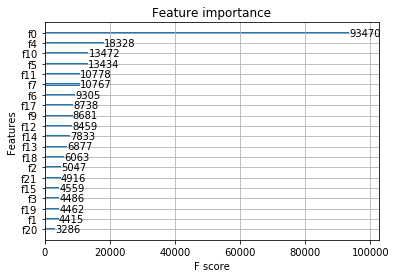

In [824]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(rf_model1)
pyplot.show()

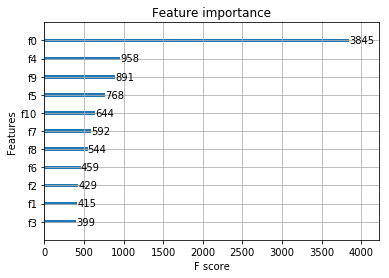

In [825]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(rf_model2)
pyplot.show()

In [826]:
final_res = spark.createDataFrame(pd.DataFrame(predict_res_final)).orderBy("etf_id", "etf_date").collect()

In [827]:
#export to pandas
etf_ids = []
mon_ud = []
mon_price = [] 
tue_ud = []
tue_price = []
wed_ud = []
wed_price = []
thu_ud = []
thu_price = []
fri_ud = []
fri_price = []

def encode_ud(oper_ud):
    if oper_ud == 0.0:
        return 0
    elif oper_ud == 1.0:
        return 1
    else:
        return -1

for row in final_res:
    etf_id = row["etf_id"]
    if etf_id not in etf_ids:
        etf_ids.append(etf_id)
    etf_date = row["etf_date"]
    eidx = next_date_range.index(row["etf_date"])
    if eidx == 0:
        mon_ud.append(encode_ud(row["pred_ud"]))
        mon_price.append(row["prediction"])
    elif eidx == 1:
        tue_ud.append(encode_ud(row["pred_ud"]))
        tue_price.append(row["prediction"])
    elif eidx == 2:
        wed_ud.append(encode_ud(row["pred_ud"]))
        wed_price.append(row["prediction"])
    elif eidx == 3:
        thu_ud.append(encode_ud(row["pred_ud"]))
        thu_price.append(row["prediction"])
    elif eidx == 4:
        fri_ud.append(encode_ud(row["pred_ud"]))
        fri_price.append(row["prediction"])
        
if len(mon_ud) == 0:
    mon_ud = list(0 for i in range(0,len(etf_ids)))
    mon_price = list(0.0 for i in range(0,len(etf_ids)))
if len(tue_ud) == 0:
    tue_ud = list(0 for i in range(0,len(etf_ids)))
    tue_price = list(0.0 for i in range(0,len(etf_ids)))
if len(wed_ud) == 0:
    wed_ud = list(0 for i in range(0,len(etf_ids)))
    wed_price = list(0.0 for i in range(0,len(etf_ids)))
if len(thu_ud) == 0:
    thu_ud = list(0 for i in range(0,len(etf_ids)))
    thu_price = list(0.0 for i in range(0,len(etf_ids)))
if len(fri_ud) == 0:
    fri_ud = list(0 for i in range(0,len(etf_ids)))
    fri_price = list(0.0 for i in range(0,len(etf_ids)))
    
dic = {"ETFid": etf_ids, 
       "Mon_ud": mon_ud, "Mon_cprice": mon_price,
       "Tue_ud": tue_ud, "Tue_cprice": tue_price,
       "Wed_ud": wed_ud, "Wed_cprice": wed_price,
       "Thu_ud": thu_ud, "Thu_cprice": thu_price,
       "Fri_ud": fri_ud, "Fri_cprice": fri_price
      }
final_df = pd.DataFrame(data=dic)[['ETFid','Mon_ud','Mon_cprice','Tue_ud','Tue_cprice',
                                  'Wed_ud','Wed_cprice','Thu_ud','Thu_cprice',
                                  'Fri_ud','Fri_cprice']]
final_df

,ETFid,Mon_ud,Mon_cprice,Tue_ud,Tue_cprice,Wed_ud,Wed_cprice,Thu_ud,Thu_cprice,Fri_ud,Fri_cprice
0,0050,-1,81.434120,1,81.699852,1,81.875061,1,81.883087,-1,81.834991
1,0051,1,32.849442,-1,32.651577,-1,32.471878,-1,32.189926,-1,32.051208
2,0052,-1,52.970402,-1,52.780193,1,52.863819,1,52.933586,-1,52.860264
3,0053,-1,35.220493,-1,35.015087,-1,34.794342,-1,34.450500,-1,34.152782
4,0054,-1,23.701176,-1,23.609793,-1,23.352571,-1,23.196156,-1,22.871033
5,0055,1,17.426779,-1,17.412596,-1,17.385267,1,17.523104,1,17.596409
6,0056,1,25.611774,-1,25.561787,-1,25.467873,-1,25.444010,-1,25.253284
7,0057,-1,49.825462,1,49.884335,1,49.953392,-1,49.513767,-1,49.035892
8,0058,-1,46.167049,-1,45.792023,-1,45.637592,-1,45.404621,-1,45.012569
9,0059,1,42.592716,1,42.765167,1,42.951015,1,42.995621,-1,42.976696


In [828]:
final_df.to_csv(Path.replace("file:","") + "/etf_price_pred.csv",index=False)

In [829]:
#ll = [46.92, 47.31, 47.0, 46.79, 46.49, 46.66, 47.0, 46.96, 47.0]
print(list(0 for i in range(0,5)))
ll = [46.92, 47.31, 47.0, 46.79, 46.49, 46.66]
win_len=5
print(ll[0])
print(ll[0: -1])
print(list(map(lambda x,y : x - y, ll[1:], ll[0: -1])))
for x in ll[win_len:]:
    print(x)
ema = sum(ll[:win_len])/len(ll[:win_len])
print(ema)
for price in ll[win_len:]:
    ema = (ema*(win_len-1)+price*2)/(win_len+1)
tup1, tup2 = (1,2)
print(tup1, ' ', tup2)
tup = (3,4)
print(tup[0], ' ', tup[1])
list(range(0,2))
test_dic = {}
test_dic.update({"0051": assembler})
print(test_dic['0051'])
print([x for x in next_date_range if x not in ignore_dates])

[0, 0, 0, 0, 0]
46.92
[46.92, 47.31, 47.0, 46.79, 46.49]
[0.39000000000000057, -0.3100000000000023, -0.21000000000000085, -0.29999999999999716, 0.1699999999999946]
46.66
46.902
1   2
3   4


NameError: name 'assembler' is not defined